In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras.utils as ku 
import pickle
import logging

from generators import PasswordBatchGenerator
from data_preparation import construct_subsequences, ff_labels, rnn_labels, add_spaces, transform_password, pad_and_tokenize
from predict_utils import predict_letter, predict_next_letter, predict_password

print(tf.keras.__version__)
tf.test.gpu_device_name()

2023-01-23 20:55:36.283425: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.11.0


2023-01-23 20:55:40.156562: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-23 20:55:40.393565: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-23 20:55:40.410281: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-23 20:55:40.410598: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_nod

'/device:GPU:0'

In [4]:
try:
    with open('data.pkl', 'rb') as file:
        df = pickle.load(file)
except:
    # Load the Password list into Memory
    url = "https://raw.githubusercontent.com/danielmiessler/SecLists/master/Passwords/Common-Credentials/10-million-password-list-top-1000000.txt"

    df_in = pd.read_csv(url, header=None)

    df = transform_password(df_in)
    with open('data.pkl', 'wb') as file:
        # Cache Data
        pickle.dump(df, file)

In [5]:
limit = len(df)
sequences = construct_subsequences(df, limit=len(df))

In [6]:
from keras.preprocessing.text import Tokenizer

#We us a Tokenizer to code each Letter into a number

tokenizer  = Tokenizer(filters=None, char_level=True, lower=False)
tokenizer.fit_on_texts(sequences)

# Translation from Word to Token and back
word2idx = tokenizer.word_index
idx2word = tokenizer.index_word
vocab_size = len(word2idx) + 1

In [7]:
# The one hot matrix is nice, but we don't need that
#1. get max password length

max_length = max([len(x) for x in sequences])

In [8]:
tok_sequence = pad_and_tokenize(sequences, tokenizer, max_length)

In [9]:
predictors, label = ff_labels(tok_sequence, vocab_size)

In [10]:
# Init generator
batch_size= 10_000
training_batch = PasswordBatchGenerator(predictors, label, batch_size)

In [11]:
try:
  with open(f'/app/models/ff_model_{str(limit)}.pkl', 'rb') as file:
      ff_model = pickle.load(file)
      logging.info(ff_model.summary())
except:# FileNotFoundError:
  ff_model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, input_shape=(vocab_size,), activation="sigmoid"),
    tf.keras.layers.Dense(vocab_size, activation='softmax')
  ])
  ff_model.compile(
                #optimizer='rmsprop',
                loss='categorical_crossentropy',
                optimizer='adam')

  ff_model.fit( training_batch , epochs=100, verbose=1)

  # cache the model
  with open(f'/app/models/ff_model_{str(limit)}.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(ff_model, file)

Keras model archive loading:
File Name                                             Modified             Size
metadata.json                                  2023-01-22 15:15:40           64
config.json                                    2023-01-22 15:15:40         1402
variables.h5                                   2023-01-22 15:15:40       315912
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
...metrics
......mean
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........2
.........3
.........4
.........5
.........6
.........7
.........8
...vars
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               12416     
                                                    

2023-01-23 20:57:10.926377: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-23 20:57:10.926932: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-23 20:57:10.927321: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-23 20:57:10.929815: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-23 20:57:10.930250: I tensorflow/compile

1/1 [==============================] - 2s 2s/step


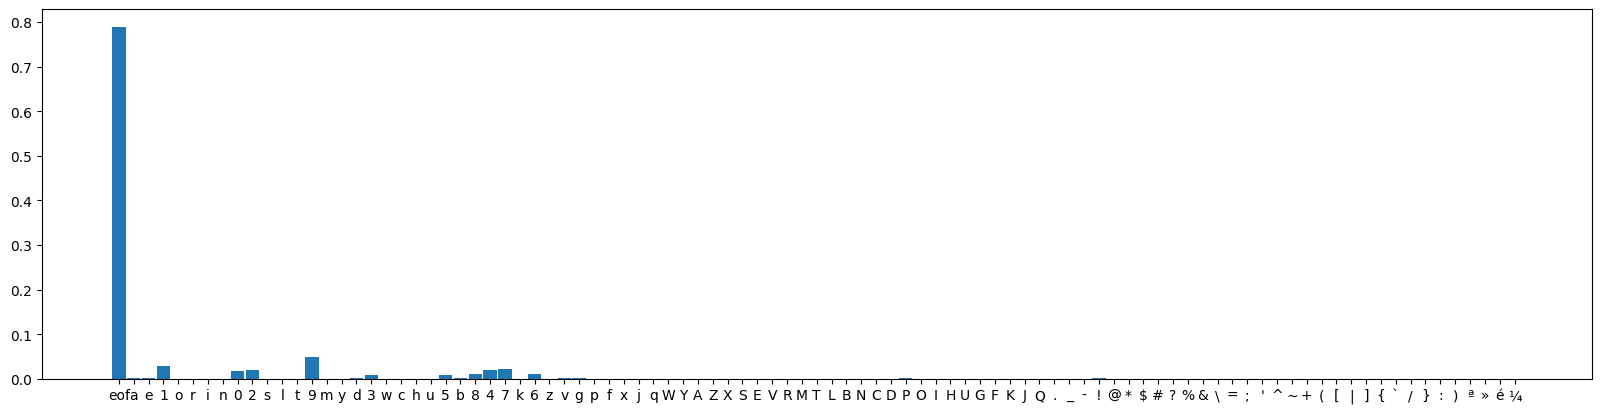

1/1 [==============================] - 0s 27ms/step


'FGD'

In [12]:
predict_next_letter("LOV", ff_model, tokenizer, True)
predict_password("FGD", ff_model, tokenizer )

In [13]:
logging.info(ff_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               12416     
                                                                 
 dense_1 (Dense)             (None, 96)                12384     
                                                                 
Total params: 24,800
Trainable params: 24,800
Non-trainable params: 0
_________________________________________________________________


In [14]:
# Split the Data into trainset and labels

predictors, label = rnn_labels(tok_sequence, vocab_size)

In [15]:
# Init generator
batch_size= 10_000
training_batch = PasswordBatchGenerator(predictors, label, batch_size)

In [16]:
try:
  with open(f'/app/models/rnn_model_{str(limit)}.pkl', 'rb') as file:
      rnn_model = pickle.load(file)
      logging.info(rnn_model.summary())
except FileNotFoundError:
  rnn_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 10, input_length=max_length-1), #Turns positive integers (indexes) into dense vectors of fixed size.
    tf.keras.layers.Masking(mask_value=0),
    tf.keras.layers.SimpleRNN(100), # skips masked timesteps
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(vocab_size, activation='softmax')
  ])
  rnn_model.compile(
                #optimizer='rmsprop',
                loss='categorical_crossentropy',
                optimizer='adam')

  rnn_model.fit( training_batch , epochs=100, verbose=1)

  # cache the model
  with open(f'/app/models/rnn_model_{str(limit)}.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(rnn_model, file)

Keras model archive loading:
File Name                                             Modified             Size
metadata.json                                  2023-01-22 18:28:44           64
config.json                                    2023-01-22 18:28:44         2383
variables.h5                                   2023-01-22 18:28:44       287424
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers
......dense
.........vars
............0
............1
......dropout
.........vars
......embedding
.........vars
............0
......masking
.........vars
......simple_rnn
.........cell
............vars
...............0
...............1
...............2
.........vars
...metrics
......mean
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Model: "sequential"
______________________________________________

In [17]:
try:
  with open(f'/app/models/lstm_model_{str(limit)}.pkl', 'rb') as file:
      lstm_model = pickle.load(file)
      logging.info(lstm_model.summary())
except:
  lstm_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 10, input_length=max_length-1), #Turns positive integers (indexes) into dense vectors of fixed size.
    tf.keras.layers.Masking(mask_value=0),
    tf.keras.layers.LSTM(100), # skips masked timesteps
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(vocab_size, activation='softmax')
  ])
  lstm_model.compile(
                #optimizer='rmsprop',
                loss='categorical_crossentropy',
                optimizer='adam')

  lstm_model.fit( training_batch , epochs=100, verbose=1)

  # cache the model
  with open(f'/app/models/lstm_model_{str(limit)}.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(lstm_model, file)


Keras model archive loading:
File Name                                             Modified             Size
metadata.json                                  2023-01-22 22:24:24           64
config.json                                    2023-01-22 22:24:24         2466
variables.h5                                   2023-01-22 22:24:24       687008
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers
......dense
.........vars
............0
............1
......dropout
.........vars
......embedding
.........vars
............0
......lstm
.........cell
............vars
...............0
...............1
...............2
.........vars
......masking
.........vars
...metrics
......mean
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Model: "sequential_1"
__________________________________________________

In [19]:
import pickle

# pickle model
with open('/root/model.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(lstm_model, file)

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......dense
.........vars
............0
............1
......dropout
.........vars
......embedding
.........vars
............0
......lstm
.........cell
............vars
...............0
...............1
...............2
.........vars
......masking
.........vars
...optimizer
......vars
.........0
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-01-23 20:57:21           64
config.json                                    2023-01-23 20:57:21         2466
variables.h5                                   2023-01-23 20:57:21       238552


1/1 [==============================] - 0s 26ms/step


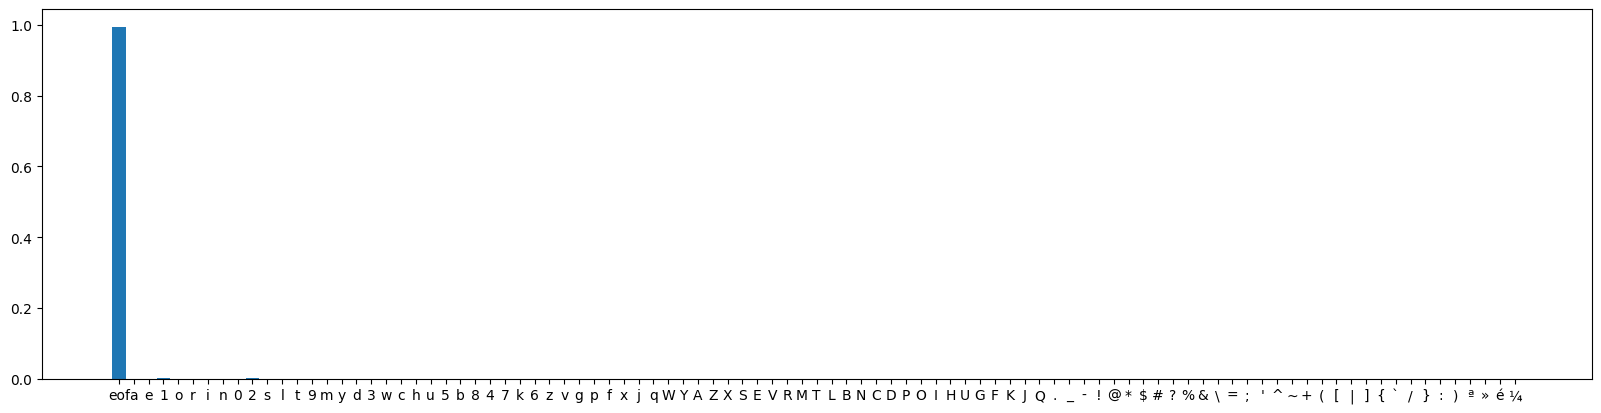

1/1 [==============================] - 0s 67ms/step


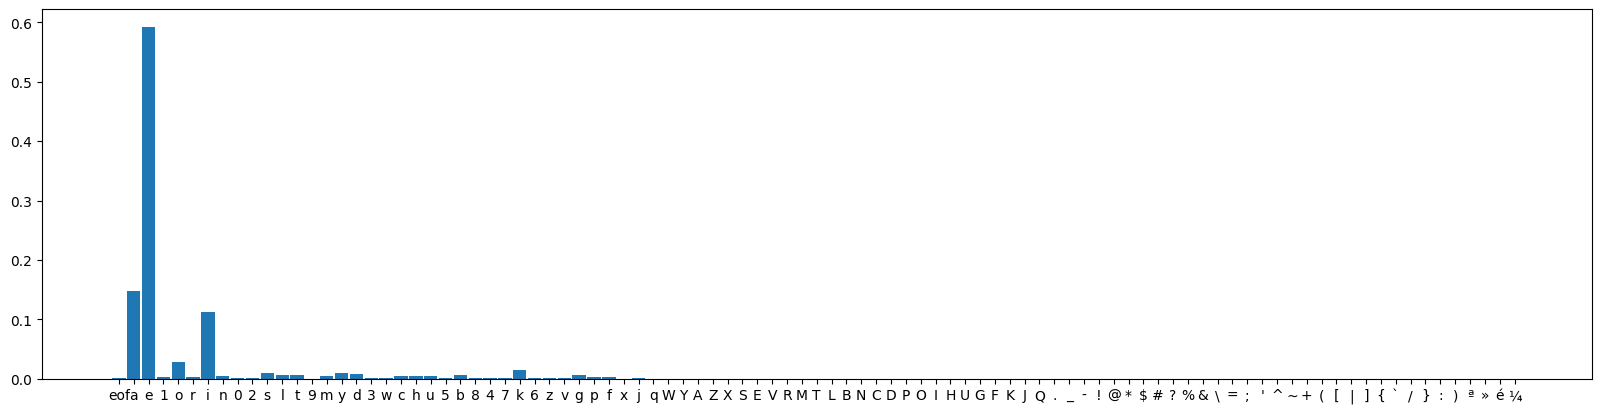

1/1 [==============================] - 0s 32ms/step


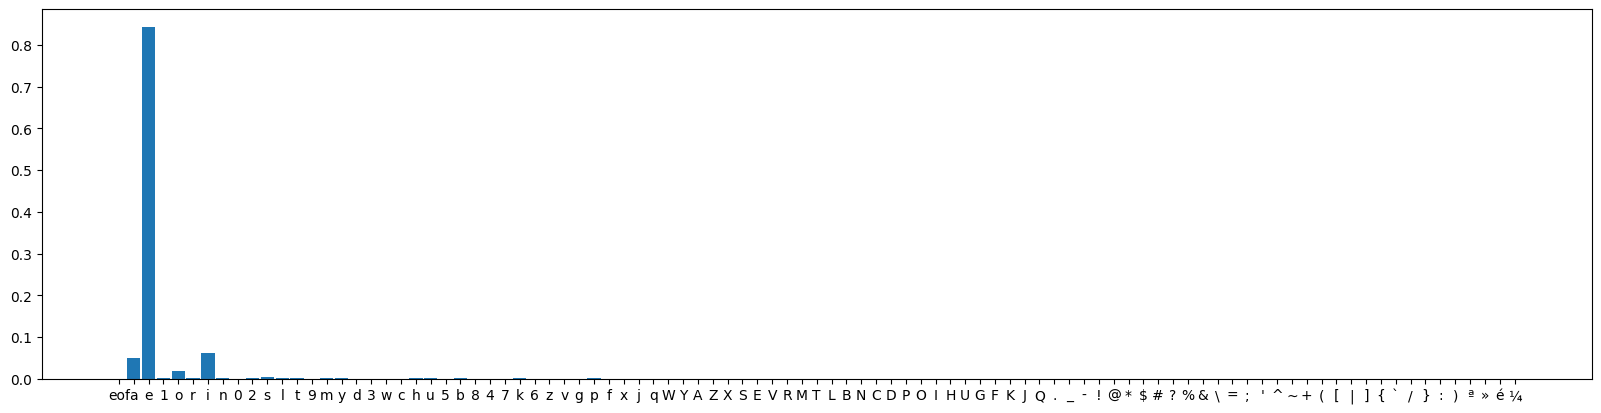

'e'

In [23]:
predict_next_letter("lov", ff_model, tokenizer, True)
predict_next_letter("lov", rnn_model, tokenizer, True)
predict_next_letter("lov", lstm_model, tokenizer, True)

In [44]:
print( predict_password("lov", ff_model, tokenizer) )
print( predict_password("lov", rnn_model, tokenizer) )
print( predict_password("lov", lstm_model, tokenizer) )

1/1 [==============================] - 0s 29ms/step
lov
1/1 [==============================] - 0s 30ms/step
loveeton98
1/1 [==============================] - 0s 32ms/step
lovello


In [22]:
#https://jhui.github.io/2017/03/15/RNN-LSTM-GRU/
#https://www.simplilearn.com/tutorials/deep-learning-tutorial/rnn
#https://www.kaggle.com/code/namansood/nlp-guide-next-word-prediction-and-deep-learning
#https://stackoverflow.com/questions/43341374/tensorflow-dynamic-rnn-lstm-how-to-format-input
#https://r2rt.com/recurrent-neural-networks-in-tensorflow-i.html
#https://medium.com/@shivambansal36/language-modelling-text-generation-using-lstms-deep-learning-for-nlp-ed36b224b275
#https://ai.stackexchange.com/questions/18198/what-is-the-difference-between-lstm-and-rnn#:~:text=The%20main%20difference%20between%20an%20LSTM%20unit%20and,better%20the%20flow%20of%20information%20through%20the%20unit.